## Relationships between words
### n-grams and correlations
Read: http://tidytextmining.com/ngrams.html

Exploring relationships and connections between words.
1. Tokenizing by n-gram, here by bigrams for a start
2. Counting and filtering n-grams: Most common bigrams, then remove the ones where at least one is a stop word.
3. Analyzing bigrams: one bigram per row: look at the tf-idf (the one with the highest), can be visualized for each document(/book in example).
4. Using them to provide context in sentiment analysis: The approach is to count certain word segments like "happy" and "not happy". We examine how often sentiment-associated words are preceded by "not" or other negating words. We use the `AFINN lexicon for sentiment analysis`. Is there something similar in german for sentiment analysis? -> http://www.ulliwaltinger.de/sentiment/ (gives negative, positive and neutral words in tsv-format, not sure if the words have a "sentiment score")
5. Calculate sentiment score per comment
6. Visualize a network of bigrams: node1 = word1 -> node2 = word2 of bigram, weight given by the number of occurence of the bigram. For each word we only show the words that follows it the most as connected directed node. Only show bigrams that occured at least x times.  
An useful and flexibel way to visualize relational data. - This is a visualization of a Markov chain.
7. Put the whole thing built so far into a function for usage on other texts
8. We may be interested in words that tend to co-occur within particular documents or particular chapters, even if they don't occur next to each other. Turn text into a wide matrix first for that.  
Counting and correlating among sections: Package like `widyr` in R for that? (`pairwise_count`)
9. Most common co-occuring words not that meaningful since they're also the most common individual words. We may instead want to examine correlation among words, which indicates how often they appear together relative to how often they appear separately (phi coefficient ~ pearson correlation for binary data).  
Pick some interesting words and look at their correlations. Then plot a graph for highest correlations like above.
    
Pairs of consecutive words might capture structure that isn't present when one is just counting single words, and may provide context that makes tokens more understandable (for example "pulteney street" instead of "pulteney" only). However, the per-bigram counts are also sparser since they are rarer.

In [118]:
# Initialize libraries and data
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(color_codes=True)

from time import time
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').sample(10000) # crop because battery life, skews data
# Make float better readable
pd.options.display.float_format = '{:.3f}'.format

df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category).astype('category')

df_art = df_art[df_art['text'].notnull()]

#df_art.groupby('cat').size()

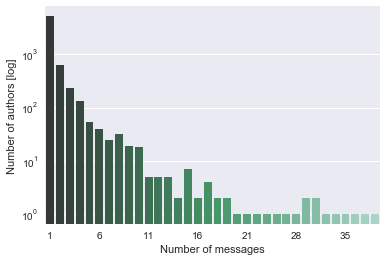

Authors with 1 message: 0.521
Authors with 2 messages: 0.063


In [119]:
# Explore relationship between authors and their number of messages
aut = df_com.groupby('aut').size()

v = aut.value_counts()
ax = sns.barplot(x=np.array(v.keys()), y=v.values, palette="BuGn_d")
ax.set_yscale('log')  # set_yscale is a function, not a string
n = 5
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])
plt.ylabel('Number of authors [log]')
plt.xlabel('Number of messages')
plt.show()

print("Authors with 1 message: {:.3f}".format(v.iloc[0] / aut.sum()))
print("Authors with 2 messages: {:.3f}".format(v.iloc[1] / aut.sum()))

## Topic modeling with articles
Read: http://tidytextmining.com/topicmodeling.html

Use LDA: Each document a mixture of topics and each topic a mixture of words.

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Parameter selection is intuitive so far
n_samples = len(df_art)
n_features = 100
n_components = 15 # Topics
n_top_words = 30
VERBOSE = True

no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, "
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei, "
stop_words += "nichts, zwei, drei, ab, keine"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "#%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

data_samples = df_art['text']

# tf-idf features for NMF (non-negative matrix factorization)
tfidf_vectorizer = TfidfVectorizer(max_df=0.3, min_df=2, preprocessor=no_numbers,
                                   max_features=n_features,
                                   stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# term frequency (tf) for features for LDA
tf_vectorizer = CountVectorizer(max_df=0.3, min_df=2, preprocessor=no_numbers,
                                max_features=n_features,
                                stop_words=stop_words)
tf = tf_vectorizer.fit_transform(data_samples)

# Fit the NMF model
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

if VERBOSE: print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..." % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

if VERBOSE: print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(lda, tf_feature_names, n_top_words)
print('Finished.')

Fitting LDA models with tf features, n_samples=2199 and n_features=100...

Topics in LDA model:
#0: polizei frau mann worden sagte jährige seien gewesen laut waren sda ihrer menschen beim hatten seit soll rund jahren dort konnte hätten leben werde zudem während ins weitere ende uhr 

#1: uhr sda video beim bereits august will ersten konnte personen letzten ins beiden wurden zwischen dabei rund heute gut zudem sagte weitere wegen während minuten seit ihrer zürich ende allerdings 

#2: jahren immer jahre seit video jetzt jahr jährige beim bereits seinen geht ersten dieses mal minuten ins seinem etwas dabei erst neue letzten gibt weil kein sehen machen allem heute 

#3: lassen während neue dabei dies allerdings dazu beim jetzt weitere gibt weil anderen damit beiden wurden allem rund mal wegen sehen seinem minuten viele immer ihren leben ob gut laut 

#4: franken millionen soll jahr rund seit jahren sollen bereits neue laut damit zudem vier will etwa schweizer sda ende müssen werde allerdi

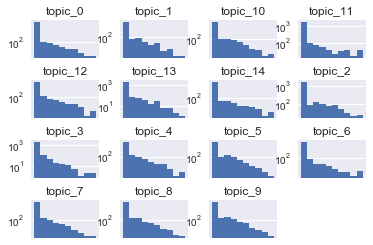

In [149]:
# Plot how many articles belong to each topic
topic_cols = list(map(lambda x: 'topic_' + str(x), range(0, n_components)))

# Probability for each document to belong to a topic
def get_probs_for_topics(text, tf_vectorizer, lda):
    lf = lda.transform(tf_vectorizer.transform([text])).ravel()
    return pd.Series(lf)

t = df_art.apply(lambda x: get_probs_for_topics(x['text'], tf_vectorizer, lda), axis=1)
t.columns = topic_cols
df_art = df_art.join(t, lsuffix='_left')

# For each topic, how is the distribution of comments
# = distribution in the columns topic_0, topic_1, ...
column = []
for i in range(0, n_components):
    column.append('topic_' + str(i))
axes = df_art.hist(column=column, log=True)
plt.setp(axes, xticks=[]) # Remove xtick labels
plt.subplots_adjust(hspace=0.6)

In [ ]:
# To which 20min-category do the topics belong to?
topic_cols = list(map(lambda x: 'topic_' + str(x), range(0, n_components)))
t = df_art[topic_cols + ['cat']].groupby('cat').mean()

f, axes = plt.subplots(int(n_components/2)+1, 2, sharex=True, sharey=True, figsize=(12, 12))
col=0
row=0
for topic in topic_cols:
    axes[row][col].plot(t[topic].values)
    axes[row][col].set_title(topic)

    col+=1
    if col==2:
        row += 1
        col = 0
        
plt.xticks(range(len(t)), list(t.index), rotation=90)
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.suptitle('Category per topic')
plt.show()


f, axes = plt.subplots(int(len(t)/2)+1, 2, sharex=True, sharey=True, figsize=(12, 12))
col=0
row=0
for topic in t.iterrows():
    axes[row][col].plot(topic[1].values)
    axes[row][col].set_title(topic[0])
    col+=1
    if col==2:
        row += 1
        col = 0
    
plt.xticks(range(n_components), topic_cols, rotation=90)
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
plt.suptitle('Topic per category')
plt.show()

## Topic modeling with comments

In [98]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Parameter selection is intuitive so far
n_samples = 30000
n_features = 50
n_components = 10 # Topics
n_top_words = 30
VERBOSE = True

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, "
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei, "
stop_words += "nichts"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "#%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

data_samples = df_com['con']

# tf-idf features for NMF (non-negative matrix factorization)
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=2,
                                   max_features=n_features,
                                   stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# term frequency (tf) for features for LDA
tf_vectorizer = CountVectorizer(max_df=0.7, min_df=2,
                                max_features=n_features,
                                stop_words=stop_words)
tf = tf_vectorizer.fit_transform(data_samples)

# Fit the NMF model
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
"""
if VERBOSE: print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
if VERBOSE: print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..." % (n_samples, n_features))
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', 
          max_iter=1000, alpha=.1, l1_ratio=.5).fit(tfidf)
if VERBOSE: print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(nmf, tfidf_feature_names, n_top_words)
"""
if VERBOSE: print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..." % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

if VERBOSE: print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
if VERBOSE: print_top_words(lda, tf_feature_names, n_top_words)
print('Finished.')

Fitting LDA models with tf features, n_samples=30000 and n_features=50...

Topics in LDA model:
#0: ja alles würde geld kein will selber wäre andere wer viel tun damit geht keine also macht ob sollte jahren heute mal gut menschen seit etwas jeder machen jetzt dies 

#1: viel jetzt nie soll wurde machen leben selber schweiz bin keine wirklich genau geld damit immer ja also kommt mal tun weil gibt andere jeder seit einfach menschen wohl würde 

#2: etwas genau heute macht jeder wurde gibt geld kein mal wer keine jahren machen ja würde will leider einfach geht andere wollen sollte selber nie viele seit immer bin viel 

#3: geht also gut bin schweiz keine ja machen etwas alles genau jetzt wirklich jeder viel macht wohl damit kein einfach immer mal heute viele nie müssen will menschen tun würde 

#4: einfach viele tun kommt leute machen selber wer macht will etwas viel kein würde weil gibt soll keine schweiz geht geld genau also ob leben ja wollen heute bin gut 

#5: mal müssen damit kein k

In [99]:
# For each category of 20M see how the topics are "arranged"
# For classes (score </>= threshold) how often each topic occurs in each comment
threshold = 1
topic_cols = list(map(lambda x: 'topic_' + str(x), range(0, n_components)))

len_high = len(df_com[df_com['score'] >= threshold])
len_low = len(df_com) - len_high
print("Num of comments\thigh: {}\tlow: {}".format(len_high, len_low))

# Probability for each document to belong to a topic
def get_probs_for_topics(text, tf_vectorizer, lda):
    lf = lda.transform(tf_vectorizer.transform([text])).ravel()
    return pd.Series(lf)

t = df_com.apply(lambda x: get_probs_for_topics(x['con'], tf_vectorizer, lda), axis=1)
t.columns = topic_cols
df_com = df_com.join(t, lsuffix='_left')

# Compute sums of topics per class
s = df_com[df_com['score'] >= threshold][topic_cols].sum(axis=0) / len_high
sums = pd.DataFrame(columns=['class', 'prob'])
sums['prob'] = s
sums['class'] = 'high'

s = df_com[df_com['score'] < threshold][topic_cols].sum(axis=0) / len_low
sums2 = pd.DataFrame(columns=['class', 'prob'])
sums2['prob'] = s
sums2['class'] = 'low'
sums = sums.append(sums2)

#print(sums)
print('Done.')

Num of comments	high: 7532	low: 2468
Done.


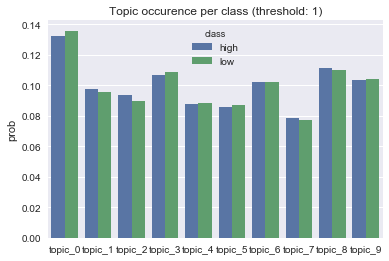

In [100]:
#print(sums_high.index)
#print(sums_high[0])
ax = sns.barplot(x=sums.index, y=sums['prob'], hue=sums['class'])
plt.title('Topic occurence per class (threshold: {})'.format(threshold))
plt.show()

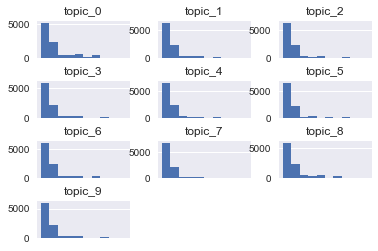

In [101]:
# For each topic, how is the distribution of comments
# = distribution in the columns topic_0, topic_1, ...
column = []
for i in range(0, n_components):
    column.append('topic_' + str(i))
axes = df_com.hist(column=column)
plt.setp(axes, xticks=[]) # Remove xtick labels
plt.subplots_adjust(hspace=0.6)

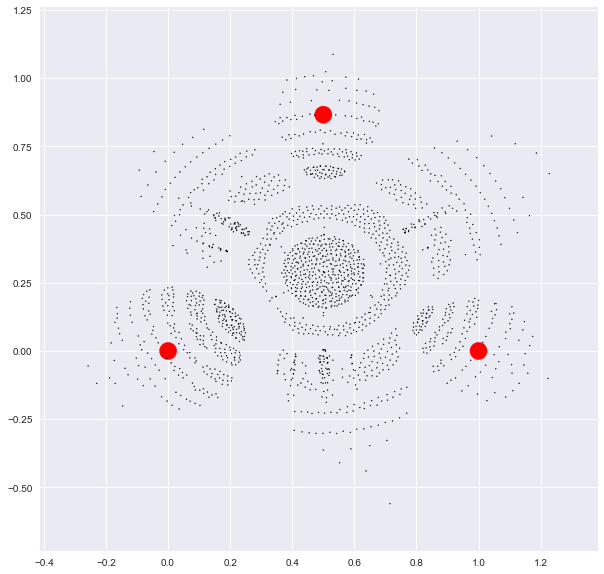

In [102]:
# Where do the comments lie compared to the topics on a cartesian plane
import random
from math import floor, sqrt
import networkx as nx

G = nx.Graph()

# Show for this topics
components_list = [0, 1, 2]

for t in components_list:
    G.add_node(t, color='red')
    
# Only for a subset because of computation time
n_graph_nodes = 2000
for i, row in df_com[:n_graph_nodes].iterrows():
    add_weighted = []
    G.add_node(i, color='black')
    for t in components_list:
        w = row['topic_' + str(t)]
        add_weighted.append((i, t, w))
        
    G.add_weighted_edges_from(add_weighted)
    
nodes = G.nodes()
colors = [G.node[n]['color'] for n in nodes]
size_by_color = {'red': 300, 'black': 1}
sizes = [size_by_color[G.node[n]['color']] for n in nodes]
    
fixedpos = {0:(0,0), 1:(1,0), 2: (0.5, sqrt(3/4))}
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, fixed = fixedpos.keys(), pos = fixedpos)
nx.draw_networkx(G, pos=pos, with_labels=False, width=0, node_color=colors, node_size=sizes)

plt.show()